# **Классификация риса с использованием нейронной сети прямого распространения**

Датасет был взят с сайта Kaggle: https://www.kaggle.com/code/maryamnoroozi68/rice-classification-by-using-cnn






Датасет содержит в себе пять папок с картинками разного вида риса.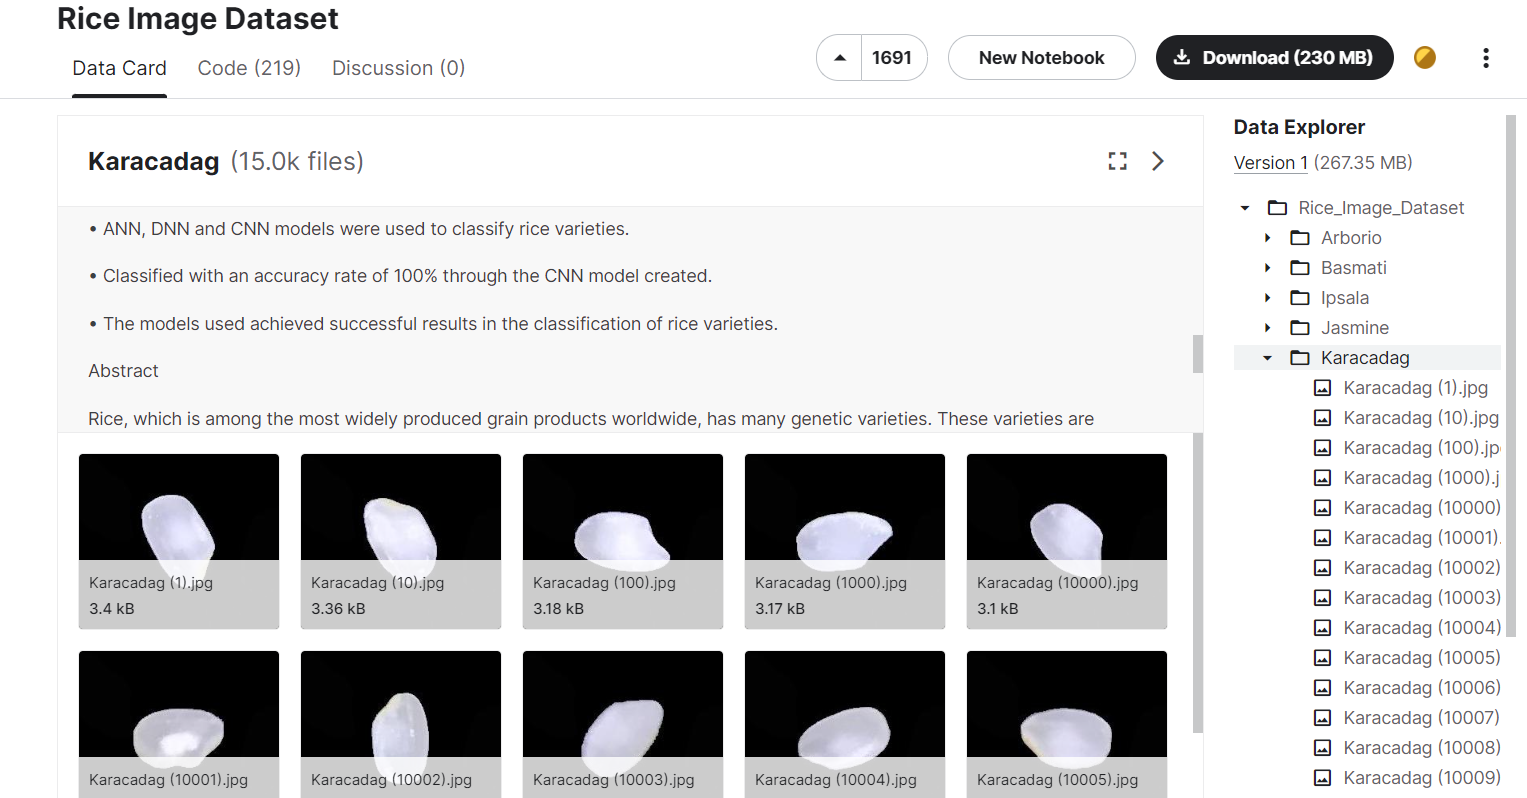

**Цель**: обучить нейронную сеть классифицировать рис на пять типов: Arborio, Basmati, Ipsala, Jasmine, Karacadag. Точность на проверочном датасете должна быть больше 90%



> **Подготовка данных для работы.**

Для этого мы загружаем нужный нам датасет с сайта Kaggle. Для этого используем свой .json файл и api датасета.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lizapankova","key":"23e3c06c932baa101061a2c7f79bf002"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d muratkokludataset/rice-image-dataset

 95% 209M/219M [00:01<00:00, 180MB/s]
100% 219M/219M [00:01<00:00, 169MB/s]


Теперь распакуем архив.

In [ ]:
from IPython.core.display import clear_output
!unzip '/content/rice-image-dataset.zip' -d '/content/rice-image-dataset'
clear_output()

In [ ]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import tensorflow as tf
import pandas as pd

Поскольку в изначальном датасете нет разделения на тренировычные и проверочные данные, то мы сами их разделим. Для этого создадим функцию, чтобы в созданные папки train и valid разделить картинки с каждым видом риса.

In [ ]:
import os
import shutil
def select(name):
  source_folder = '/content/rice-image-dataset/Rice_Image_Dataset/' + name
  train = '/content/train/' + name
  valid = '/content/valid/' + name

  file_list = os.listdir(source_folder)

  n_files_folder1 = int(0.75 * len(file_list))
  folder1_files = file_list[:n_files_folder1]

  if not os.path.exists(train):
      os.makedirs(train)

  for file_name in folder1_files:
      source_file = os.path.join(source_folder, file_name)
      destination_file = os.path.join(train, file_name)
      shutil.move(source_file, destination_file)

  if not os.path.exists(valid):
      os.makedirs(valid)

  for file_name in file_list[n_files_folder1:]:
      source_file = os.path.join(source_folder, file_name)
      destination_file = os.path.join(valid, file_name)
      shutil.move(source_file, destination_file)



In [ ]:
select('Basmati')
select('Ipsala')
select('Arborio')
select('Jasmine')
select('Karacadag')

Теперь можно создать torch датасеты.

In [ ]:
traindir = '/content/train'
testdir = '/content/valid'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as T
from IPython.display import Image
from skimage import io
from torchvision.utils import make_grid

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cpu'

Преобразуем изображения в черно-белый формат, а так же в тензор.

In [ ]:
train_transform = T.Compose([T.Grayscale(),T.ToTensor()])
test_transform = T.Compose([T.Grayscale(),T.ToTensor()])

In [ ]:
train_dataset=datasets.ImageFolder(traindir,transform=train_transform)
test_dataset=datasets.ImageFolder(testdir,transform=test_transform)

Зададим два итератора данных, которые разобьют выборки на случайные пакеты фиксированного размера (в нашем случае размер пакета равен 36)

In [ ]:
batch_size=36
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
dataloaders = {"train": train_loader,"validation": test_loader}

Посмотрим на случайные картинки с тренировочного датасета.

In [ ]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:36], nrow=8).permute(1, 2, 0).clamp(0,1))
        print(images.shape)
        break

torch.Size([36, 1, 250, 250])


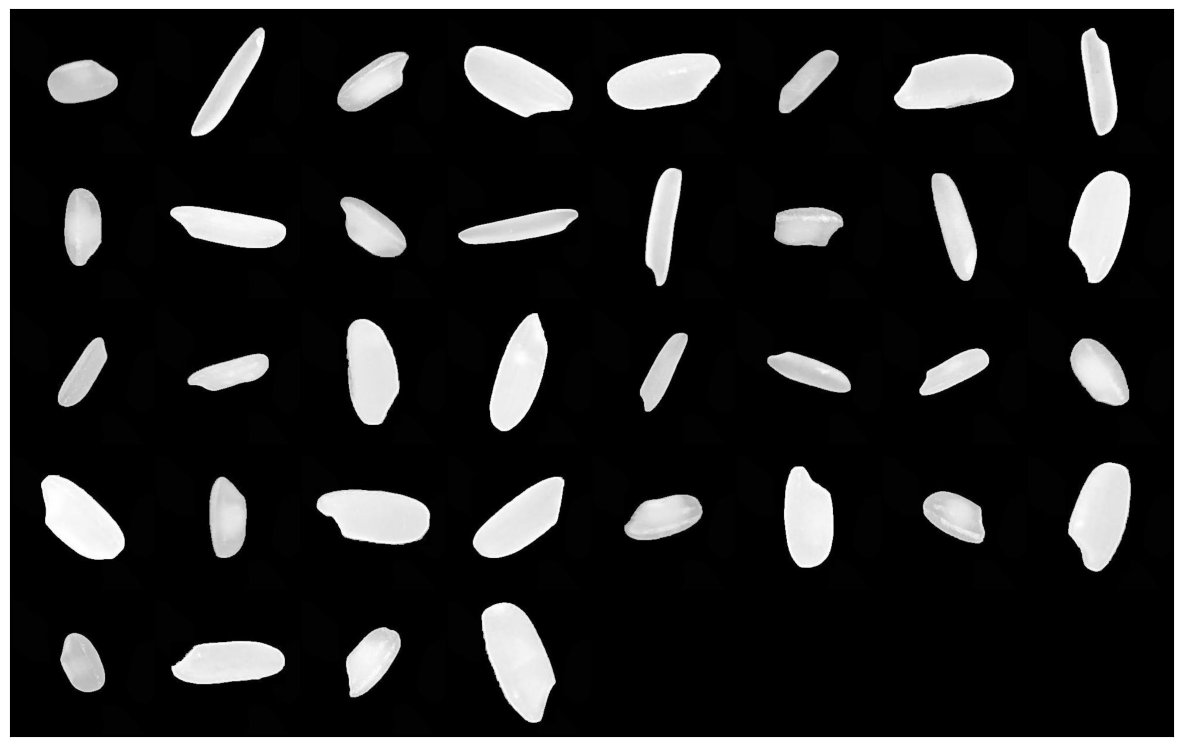

In [ ]:
show_batch(dataloaders['train'])

Теперь данные готовы к работе.



> **Создаем модель**

У нас будет простая модель нейронаой сети. Мы используем два слоя. Они имеют соответственно 250 * 250 и 128 входных и выходных нейронов для первого слоя, а для второго слоя - 128 входных нейронов и 5 выходных нейронов. 5 нейроннов как раз отражают 5 классов, на которые мы хотим по итогу разбить наши изображения.


In [ ]:
import torch.nn as nn

class Simple_NN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(250*250,128)
    self.fc2 = nn.Linear(128,5)
    self.activation = nn.LeakyReLU(inplace=True)

  def forward(self,x): # прямой проход модели
    x = x.view(-1,250*250) # распрямляем изображение в вектор
    x = self.fc1(x)
    x = self.activation(x)
    x = self.fc2(x)
    return x

Загружаем модель и подключаем.

In [ ]:
model=Simple_NN()
model.to(device)

Simple_MNIST_NN(
  (fc1): Linear(in_features=62500, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
)

In [ ]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Теперь можно подробнее взглянуть на полученную модель.

In [ ]:
from torchinfo import summary
summary(model,input_size=(1, 250, 250))

Layer (type:depth-idx)                   Output Shape              Param #
Simple_MNIST_NN                          [1, 5]                    --
├─Linear: 1-1                            [1, 128]                  8,000,128
├─LeakyReLU: 1-2                         [1, 128]                  --
├─Linear: 1-3                            [1, 5]                    645
Total params: 8,000,773
Trainable params: 8,000,773
Non-trainable params: 0
Total mult-adds (M): 8.00
Input size (MB): 0.25
Forward/backward pass size (MB): 0.00
Params size (MB): 32.00
Estimated Total Size (MB): 32.25



> **Цикл обучения простой нейронной сети**

Создадим вывод временных результатов после каждой эпохи обучения, сохраним лучшие модели и выводим матрицу ошибок. Будем использовать библиотеку ignite.



In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
!pip install pytorch-ignite --quiet

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine

In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

In [ ]:
metrics = { "loss" : Loss(criterion),
           "accuracy" : Accuracy(),
            "cm": ConfusionMatrix(num_classes=5)}

In [ ]:
train_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)
test_evaluator = create_supervised_evaluator(model, metrics = metrics, device = device)

In [ ]:
training_history = {'accuracy':[],'loss':[]}
test_history = {'accuracy':[],'loss':[]}
last_epoch = []

Собрали движок обучение и расписали метрики. Теперь создадим вывод временных результатов после каждой эпохи (для тренировчного и проверочного датасетов).

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("Результат обучения - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_test_results(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['loss']
    test_history['accuracy'].append(accuracy)
    test_history['loss'].append(loss)
    print("Результат валидации - Эпоха: {}  Сред. точность: {:.2f} Сред. ошибка: {:.5f}"
          .format(trainer.state.epoch, accuracy, loss))

Создадим раннюю остановку, если в течении двух эпох точность на проверочном датасете не увеличивается.

In [ ]:
breaker = EarlyStopping(patience = 2, score_function = lambda engine : engine.state.metrics['accuracy'],
                        trainer = trainer)
test_evaluator.add_event_handler(Events.COMPLETED, breaker);

Сохраним две самые лучшие по точности модели за время нашего обучения.

In [ ]:
to_save = {'model': model}
saver = Checkpoint(
    to_save, './models',
    n_saved=2, filename_prefix='best',
    score_name="accuracy",
    global_step_transform=global_step_from_engine(trainer),
)
test_evaluator.add_event_handler(Events.COMPLETED, saver);

Создадим шкалу прогресса.

In [ ]:
from tqdm.notebook import tqdm
profiler = HandlersTimeProfiler()
profiler.attach(trainer)
pbar = ProgressBar(persist=True,
    bar_format = '')
pbar.attach(trainer, output_transform = lambda x : {"loss" : x})

/usr/local/lib/python3.10/dist-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Распишем то, что происходит после обучения модели, а именно: выводим матрицу ошибок.

In [ ]:
@trainer.on(Events.COMPLETED)
def log_confusion_matrix(trainer):
    test_evaluator.run(test_loader)
    metrics = test_evaluator.state.metrics
    cm = metrics['cm']
    cm = cm.numpy()
    cm = cm.astype(int)
    classes = train_dataset.classes
    fig, ax = plt.subplots(figsize=(5,5))
    ax= plt.subplot()
    class_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, ax = ax,fmt="d")
    # labels, title and ticks
    ax.set_xlabel('Предположение')
    ax.set_ylabel('True')
    ax.set_title('Error matrix')
    ax.xaxis.set_ticklabels(classes,rotation=90)
    ax.yaxis.set_ticklabels(classes,rotation=0)

Наконец, запускаем нашу модель и смотрим, как она обучается. Задамим максимальное количество эпох 6.

In [ ]:
trainer.run(train_loader, max_epochs=6)

NameError: ignored

Судя по матрице, нейронной сети больше всего "тяжело дается" отличить Arborio и Karacadag. В целом, модель неплохо српавляется со своей задачей классфиикации. Ниже рассмотрим подробнее результаты обучения.



> **Итог обучения нейронной сети**

Для начала построим графики точности для тренировчной и проверочной датасетов. Узнаем, как менялась точность в течении эпох обучения.

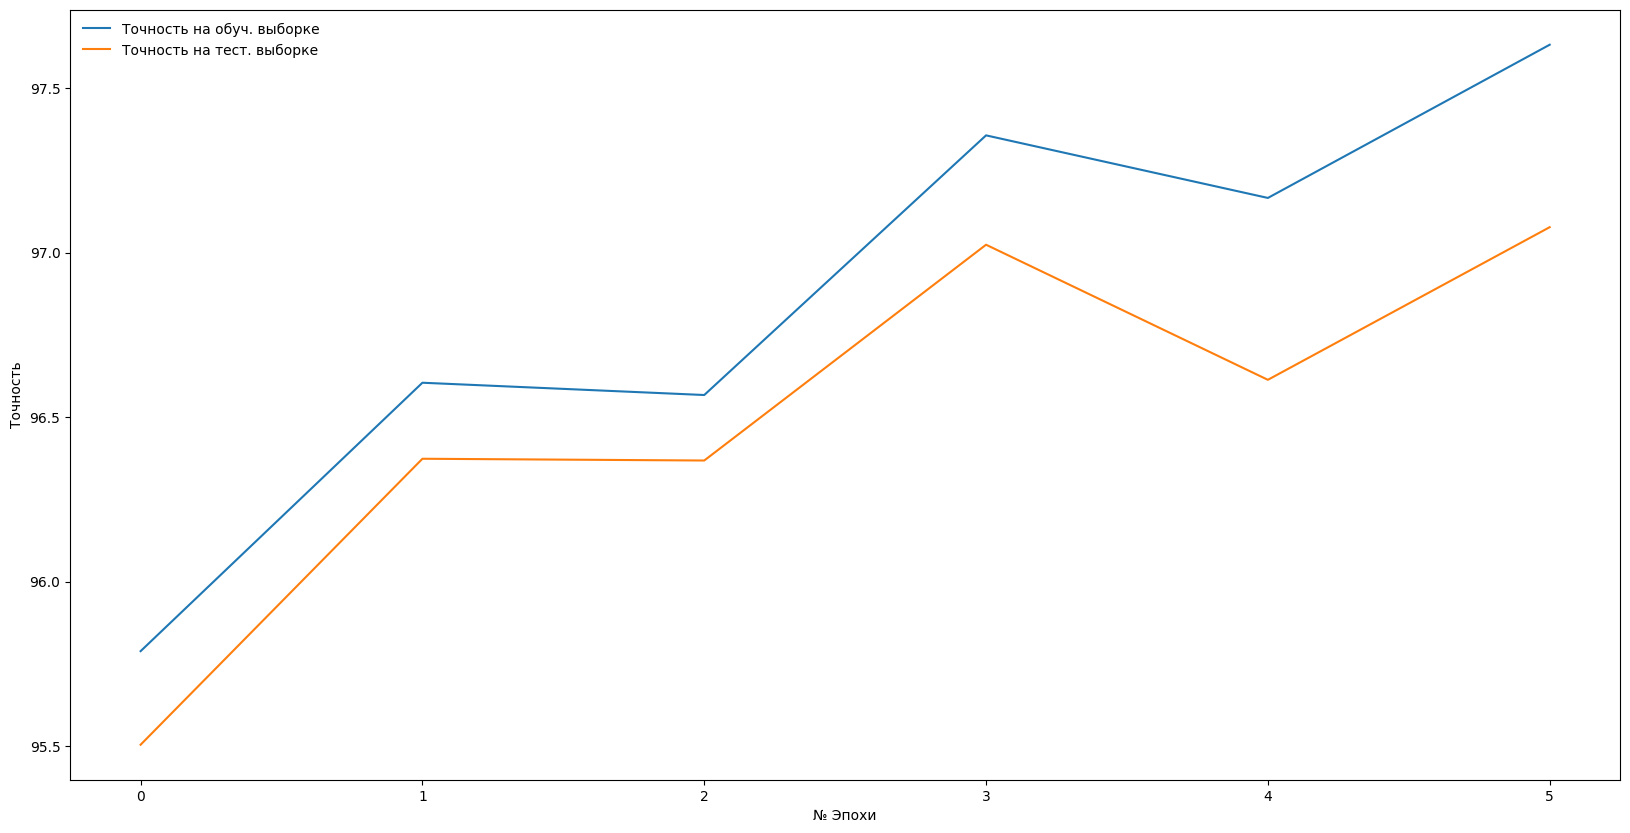

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['accuracy'],label="Точность на обуч. выборке")
plt.plot(test_history['accuracy'],label="Точность на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Точность')
plt.legend(frameon=False)
plt.show()

И узнаем, как менялась средняя ошибка.

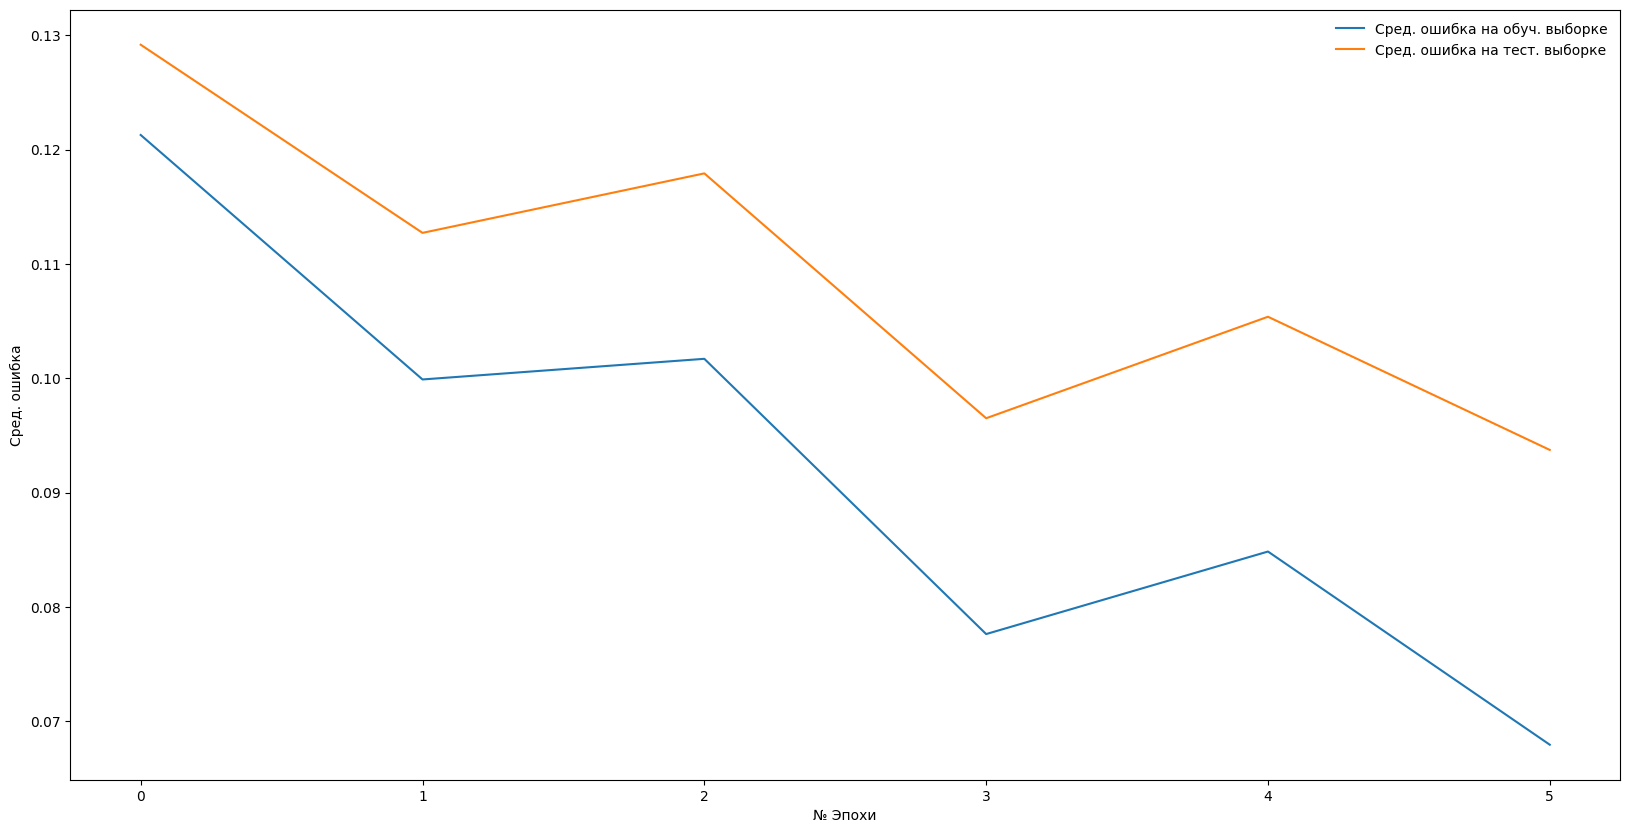

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(training_history['loss'],label="Сред. ошибка на обуч. выборке")
plt.plot(test_history['loss'],label="Сред. ошибка на тест. выборке")
plt.xlabel('№ Эпохи')
plt.ylabel('Сред. ошибка')
plt.legend(frameon=False)
plt.show()

Можно посмотреть на неправильно классифицированные рисинки.

In [ ]:
def fetch_last_checkpoint_model_filename(model_save_path):
    import os
    checkpoint_files = os.listdir(model_save_path)
    checkpoint_files = [f for f in checkpoint_files if '.pt' in f]
    checkpoint_iter = [
        int(x.split('_')[2].split('.')[0])
        for x in checkpoint_files]
    last_idx = np.array(checkpoint_iter).argmax()
    return os.path.join(model_save_path, checkpoint_files[last_idx])

model.load_state_dict(torch.load(fetch_last_checkpoint_model_filename('/content/models')))
print("Модель загружена")

Модель загружена


In [ ]:
loader = DataLoader(test_dataset, batch_size=10000, shuffle=True)

In [ ]:
dataiter = iter(loader)
images, labels = next(dataiter)
images_arr = []
labels_arr = []
pred_arr = []
model.to("cpu")
for i in range(0,10000):
    images_arr.append(images[i].unsqueeze(0))
    labels_arr.append(labels[i].item())
    ps = torch.exp(model(images_arr[i]))
    ps = ps.data.numpy().squeeze()
    pred_arr.append(np.argmax(ps))

In [ ]:
misclass=[]
for i in range(len(labels_arr)-1):
    if labels_arr[i]!=pred_arr[i]:
        misclass.append(i)

In [ ]:
len(misclass)

302

In [ ]:
classes=train_dataset.classes

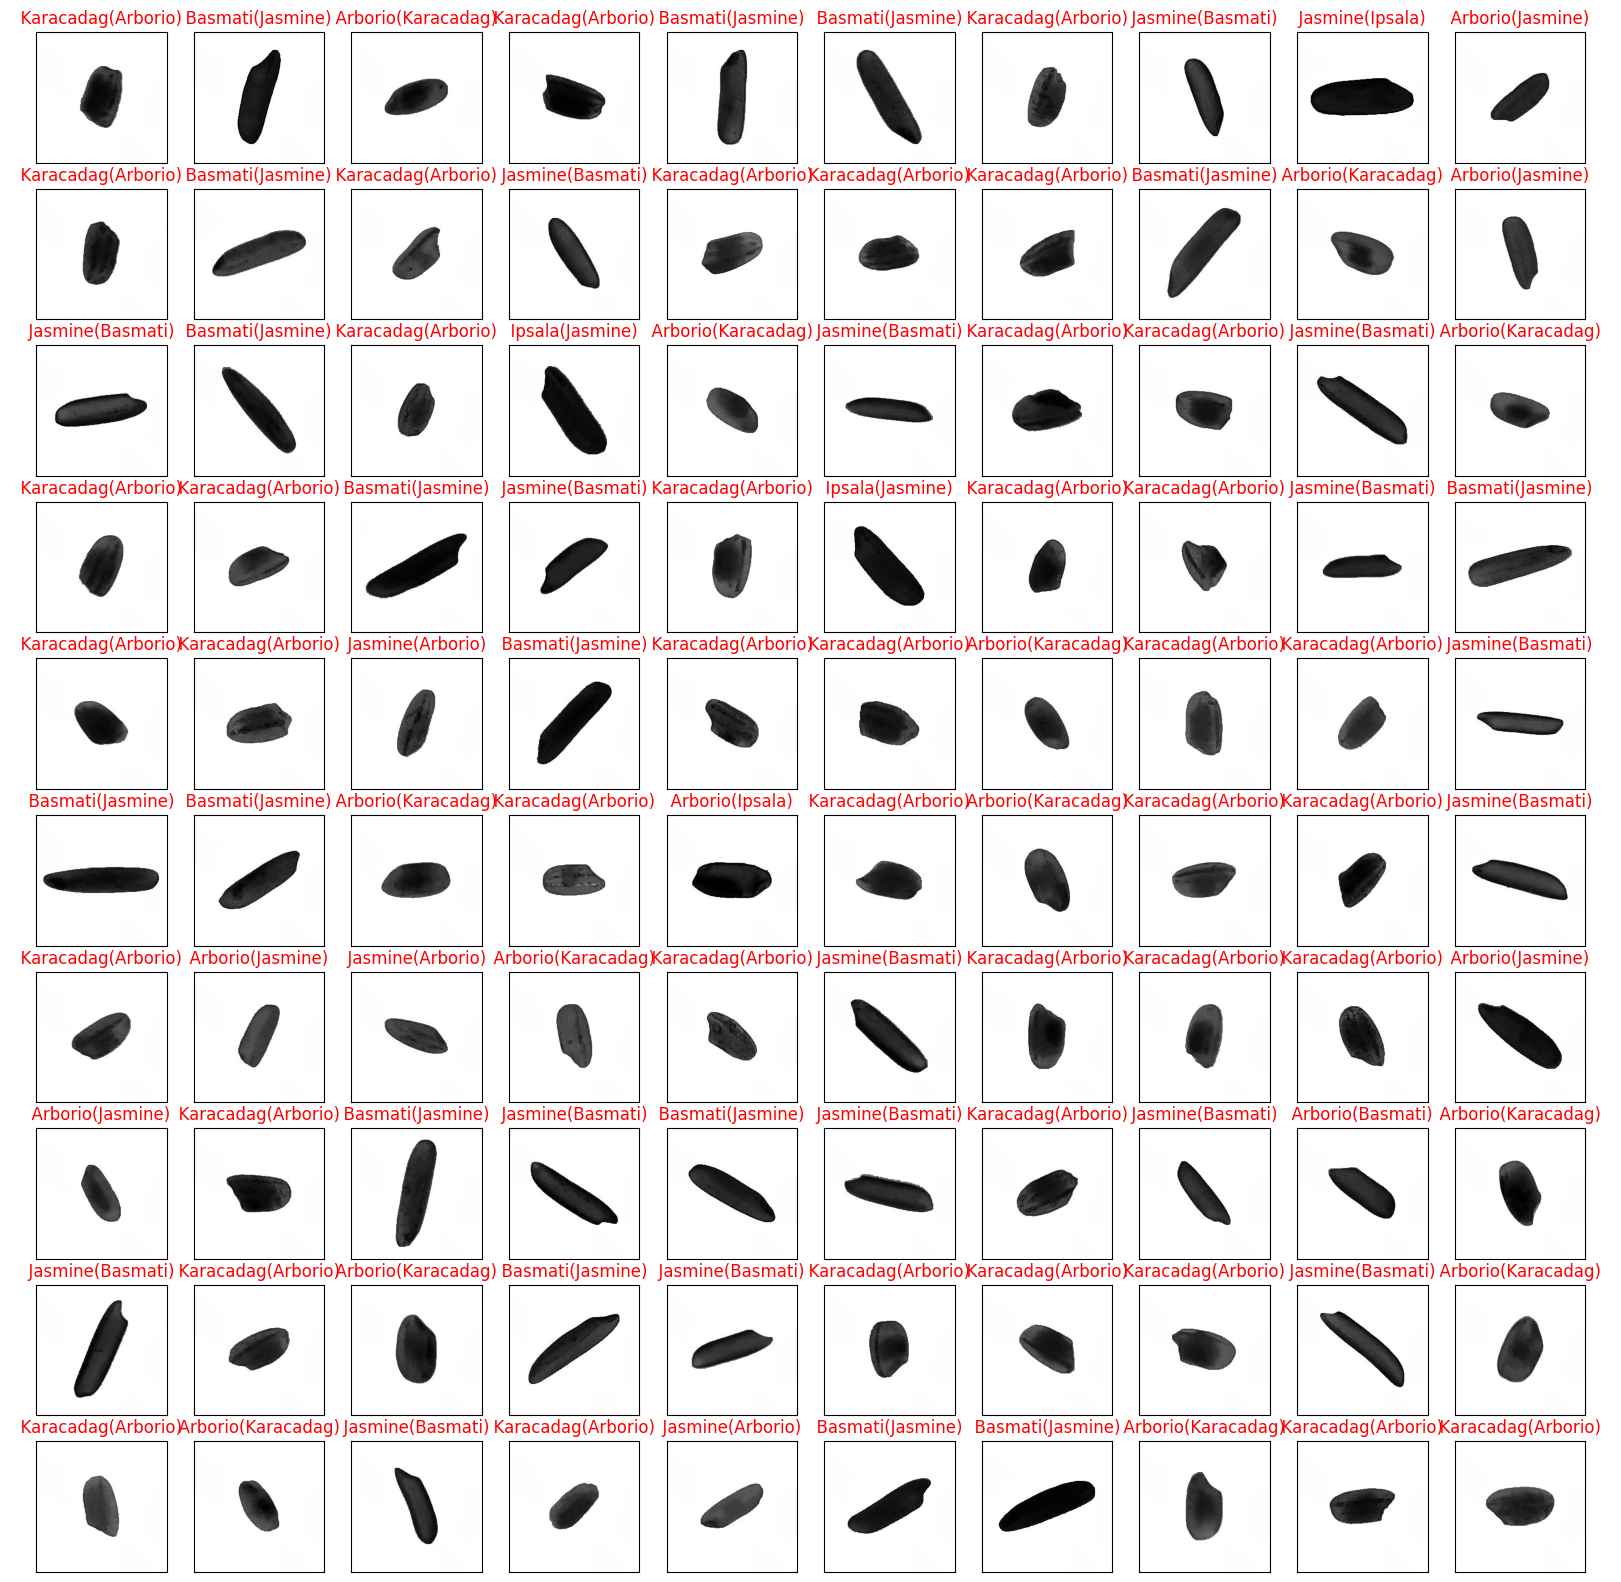

In [ ]:
fig = plt.figure(figsize=(20,20))
for i in range(100):
    ind=misclass[i]
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(images_arr[ind].view(-1,250,250).to('cpu').numpy().squeeze(),cmap='Greys')
    ax.set_title("{} ({})".format(classes[pred_arr[ind]], classes[labels_arr[ind]]),
                 color=("green" if pred_arr[ind]==labels_arr[ind] else "red"))